### Import modules

In [1]:
cd

/home/jovyan


In [36]:
import datacube 
from datacube.virtual import catalog_from_file
dc = datacube.Datacube()
service = '/home/jovyan/development/'
from datacube.helpers import write_geotiff
import numpy as np
import sys

sys.path.append("Scripts")
from dea_plotting import rgb

# product = catalog['salty']
# data = product.load(dc, **query)
# (data.vssi.squeeze()).plot.imshow()

### Locations

In [163]:
# # Adelaide:
# min_x= 550000
# max_x= 650000
# min_y= -3850000
# max_y= -3750000

# area_name: "LakeGairdner"
# min_x = 350000
# max_x = 400000
# min_y = -3500000
# max_y = -3450000

# area_name = "Lake_Eyre"
# min_x= 500000
# max_x= 600000
# min_y= -3000000
# max_y= -2900000

# # Diamantina:
# min_x= 800000
# max_x= 900000
# min_y= -2800000
# max_y= -2700000

# Gwydir:
min_x= 1600000
max_x= 1700000
min_y= -3400000
max_y= -3300000

# # Leichhardt:
# min_x= 800000
# max_x= 900000
# min_y= -2000000
# max_y= -1900000


### Set parameters

In [164]:
# x = (350000, 400000)
# y = (-3500000, -3450000)

# Name
# area_name = 'Leichhardt'
x = (min_x,max_x)
y = (min_y,max_y)
res = (-100, 100)
crs = "EPSG:3577"
time = ("2015-01-01", "2015-12-31")
query =({'time': time,
             'x':x,
            'y':y,
            'crs':crs,
            'resolution':res})
catalog = catalog_from_file(str(service)+'livingearth_australia/le_plugins/virtual_product_cat.yaml')

### Add le plugins

In [165]:
# import importlib
# import sys
# import os
# from datacube.virtual import DEFAULT_RESOLVER
# sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))
# sys.path.append(str(service)+"dea-notebooks/Scripts")
# sys.path.append(str(service)+"livingearth_australia")

# #see what's already in the resolver 
# DEFAULT_RESOLVER.lookup_table['transform']

# # Now we add the transformation we're testing
# # Get location of transformation
# transformation = "le_plugins.salt_mask_new"
# trans_loc = importlib.import_module(transformation)
# trans_class = transformation.split('.')[-1]
# DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [166]:
# #see what's now in the resolver 
# DEFAULT_RESOLVER.lookup_table['transform']

### Load data

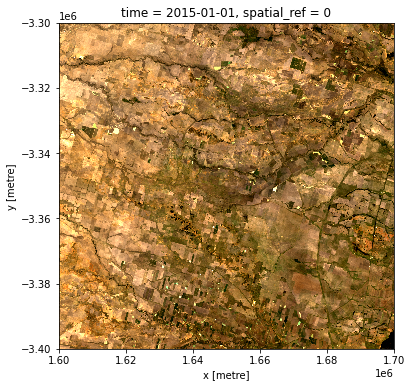

In [167]:
product = catalog['best_pixel_gm']
gm = product.load(dc, **query)
gm
# (gm.red.squeeze()).plot.imshow()

rgb(gm,bands=['red','green','blue'])

### Apply salt index

Water and salt do not have similar index values, and salt is at extremes:
- SI2
- SI3
- SI4
- SI5
- SI6
- SI7
- SI10
- BI
- VSSI


In [168]:
ds = gm

In [169]:
# Salt index list:
ds['si1'] = ds['blue']/ds['red']
ds['si2'] = ds['blue']-(ds['red']/ds['blue'])+ds['red']
ds['si3'] = (ds['green']*ds['red'])/ds['blue']
ds['si4'] = np.sqrt(ds['red']*ds['blue'])
ds['si5'] = (ds['blue']*ds['red'])/ds['green']
ds['si6'] = (ds['red']*ds['nir'])/ds['green']
ds['si7'] = np.sqrt(ds['green']*ds['red'])
ds['si8'] = np.sqrt((ds['green']**2)*(ds['red']**2)*(ds['nir']**2))
ds['si9'] = np.sqrt((ds['green']**2)*(ds['red']**2))
ds['si10'] = (ds['nir']-ds['swir1'])/(ds['nir']+ds['swir1'])
ds['sr'] = ds['nir']/ds['red']
ds['ndsi'] = (ds['red']-ds['nir'])/(ds['red']+ds['nir'])
ds['sia'] = (ds['red']/ds['blue'])*100
ds['sit'] = (ds['red']/ds['nir'])*100
ds['bi'] = np.sqrt(ds['red']**2+ds['nir']**2)
ds['pd'] = ds['nir']/(ds['nir']+ds['red'])
ds['ipvi'] = ds['nir']/(ds['nir']+ds['red'])
ds['dvi'] = ds['nir']-ds['red']
ds['ndvi'] = (ds['nir']-ds['red'])/(ds['nir']+ds['red'])             
ds['cosri'] = ((ds['blue']+ds['green'])/(ds['red']+ds['nir']))*ds['ndvi']
ds['savi'] = 1.5*(ds['nir']+ds['red'])/(ds['nir']+ds['red']+0.5)
ds['evi'] = 2.5*((ds['nir']-ds['red'])/(ds['nir']+6*ds['red']-7.5*ds['blue']+1))
ds['gdvi'] = (ds['nir']**2-ds['red']**2)/(ds['nir']**2+ds['red']**2)
ds['msi'] = ds['swir1']/ds['nir']
ds['vssi'] =  2*ds['green']-5*(ds['red']+ds['nir'])

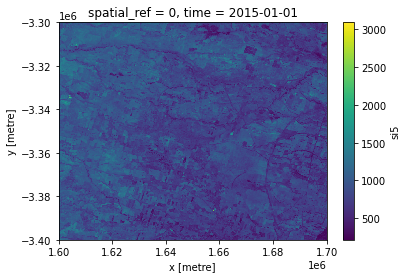

In [170]:
(ds.si5.squeeze()).plot.imshow()

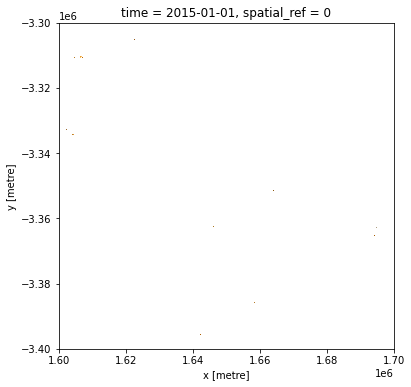

In [171]:
# Keep salty areas
masked = gm.where(ds.si2>4000)
rgb(masked,bands=['red','green','blue'])

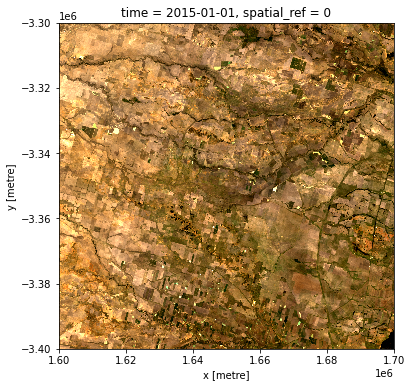

In [172]:
rgb(gm,bands=['red','green','blue'])

In [147]:
# Export

index_dict = ['si1','si2','si3','si4','si5','si6','si7','si8','si9','si10','sr','ndsi','sia','sit','bi','pd','ipvi','dvi','ndvi','cosri','savi','evi','gdvi','msi','vssi']
test_dict = ['si2','si3','si4','si5','si6','si7','si8','si9','si10','sit','bi','vssi']

for i in test_dict:
    dataset = ds[i].isel(time=0).to_dataset(name=i)
    write_geotiff('salt_indices/'+area_name+'_'+i+'.tif', dataset)

/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)
/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)
/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)
/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)
/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.util